In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Dropout

In [2]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map
    

In [3]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='../PAMAP2_Dataset/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = pd.concat([output,subject],ignore_index = True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
C:\Users\G15\AppData\Local\Temp\ipykernel_12948\1646358111.py:59: SyntaxWarning: invalid escape sequence '\s'
  subject = pd.read_table(path, header=None, sep='\s+')


In [6]:
def fix_data(data):
    data = data.drop(data[data['activity_id']==0].index)
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [7]:
data.describe()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,...,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,...,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,1.045664e+02
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,...,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,...,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,1.426340e-01,-6.129580e-01,4.914657e-03,-5.378710e-01,1.020000e+02
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,...,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,1.050000e+02
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577087e-01,6.453505e+00,6.531523e+00,-9.058870e-01,6.458670e+00,6.775980e+00,...,1.162570e-01,9.181807e-02,-1.790600e+01,1.783892e+01,3.121160e+01,5.600202e-01,6.153723e-01,5.960633e-01,4.382870e-01,1.070000e+02
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,1.090000e+02


In [8]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
result_id = data.groupby(['id']).mean().reset_index()
print('Number of uniqe ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of uniqe activitys in the data: ',len(result_act))

Size of the data:  106857960
Shape of the data:  (1942872, 55)
Number of columns in the data:  55
Number of uniqe ids in the data:  9
Numbe of uniqe activitys in the data:  12


In [9]:
def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    ax.bar(size, pd[column_a], color=plt.cm.Paired(size),label=column_a)
    
    ax.set_xticks(np.arange(len(pd)))
    ax.set_xticklabels(pd[column_b])
    ax.set_title(title)
    ax.legend(fontsize = 20)
    plt.show()

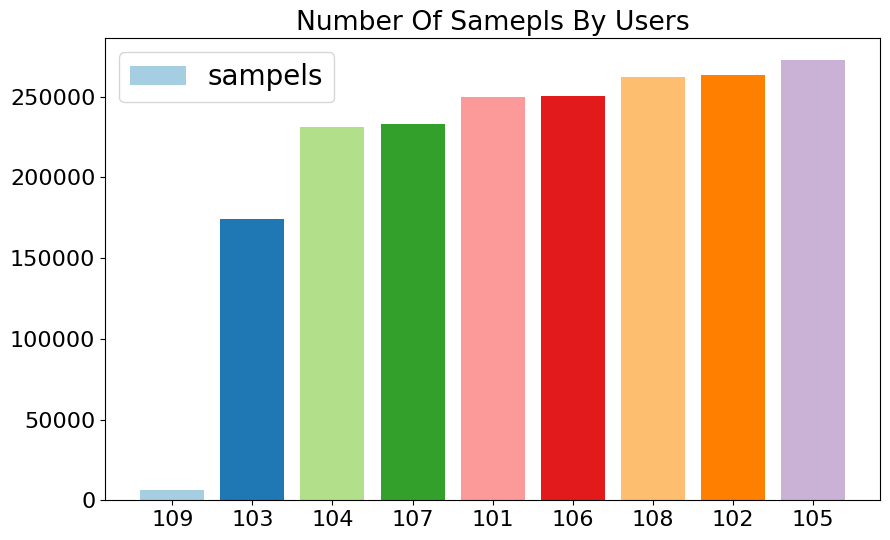

In [10]:
sampels = data.groupby(['id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['id'] = sampels['id']
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','id','Number Of Samepls By Users')

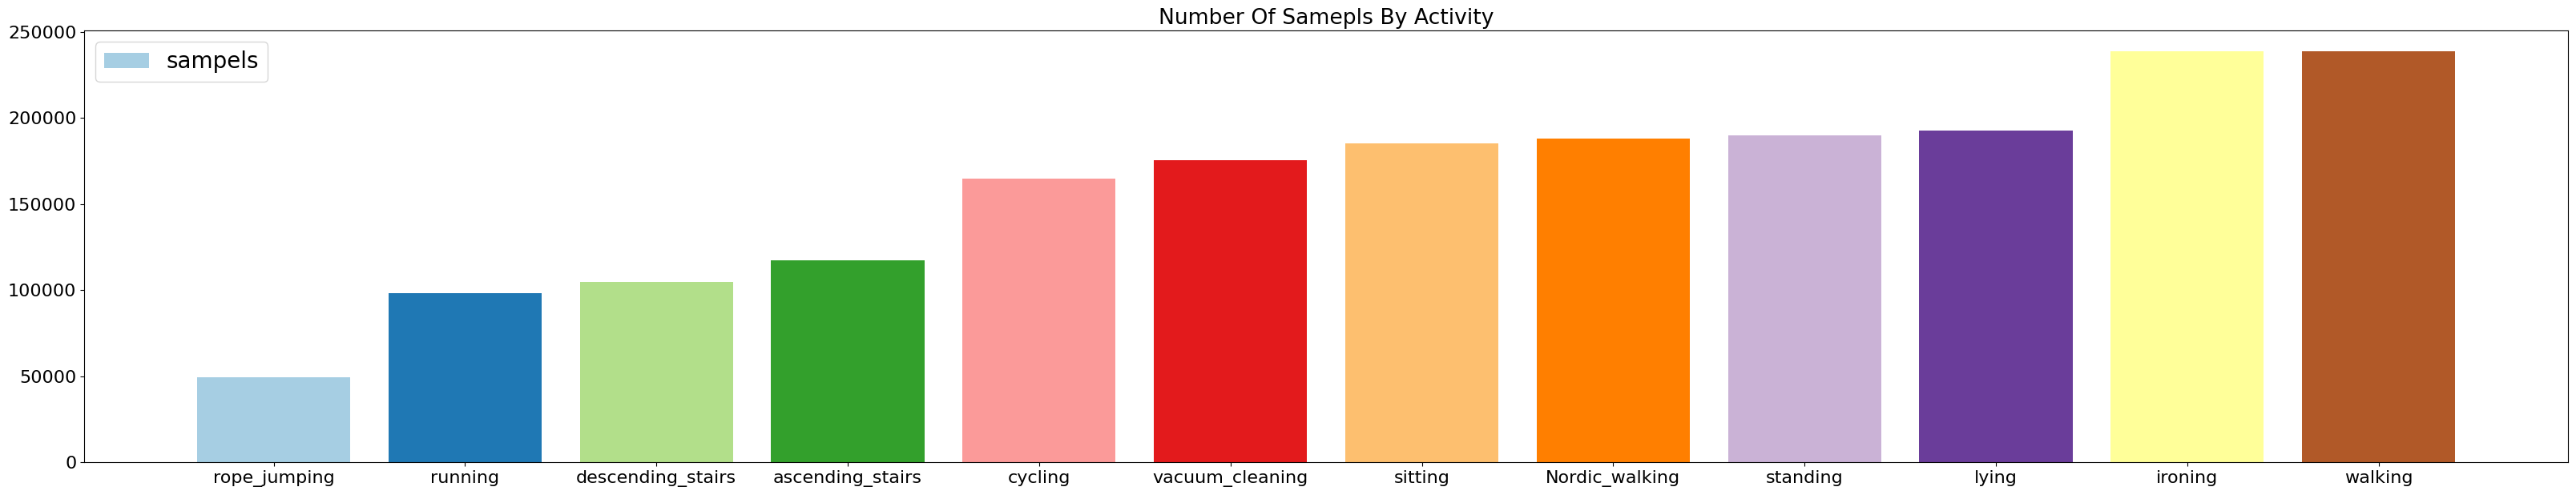

In [11]:
map_ac = load_activity_map()
sampels = data.groupby(['activity_id']).count().reset_index()
sampels_to_subject = pd.DataFrame()
sampels_to_subject['activity'] = [map_ac[x] for x in sampels['activity_id']]
sampels_to_subject['sampels'] = sampels['time_stamp']
sampels_to_subject = sampels_to_subject.sort_values(by=['sampels'])
pd_fast_plot(sampels_to_subject,'sampels','activity','Number Of Samepls By Activity',figsize=(40,7))

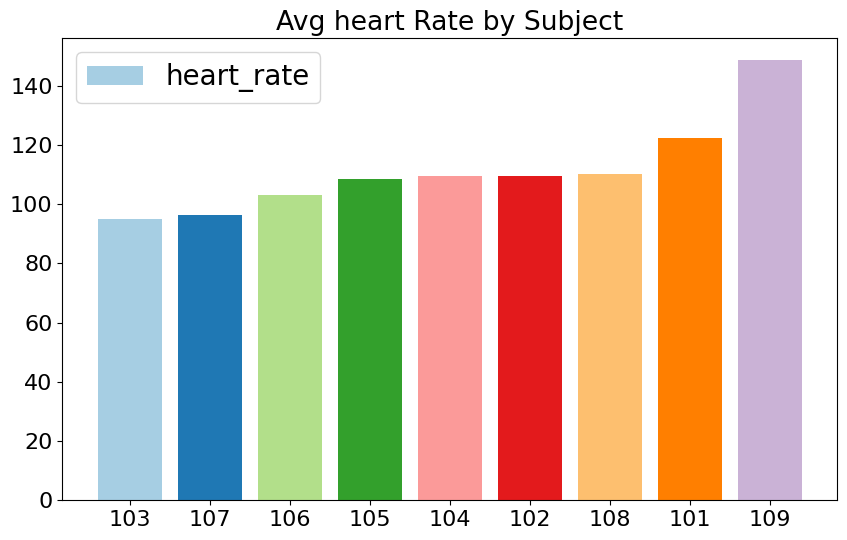

In [12]:
sampels_heart_rate = pd.DataFrame()
sampels_heart_rate['id'] = result_id['id']
sampels_heart_rate['heart_rate'] = result_id['heart_rate']
sampels_heart_rate = sampels_heart_rate.sort_values(by=['heart_rate'])
pd_fast_plot(sampels_heart_rate,'heart_rate','id','Avg heart Rate by Subject')

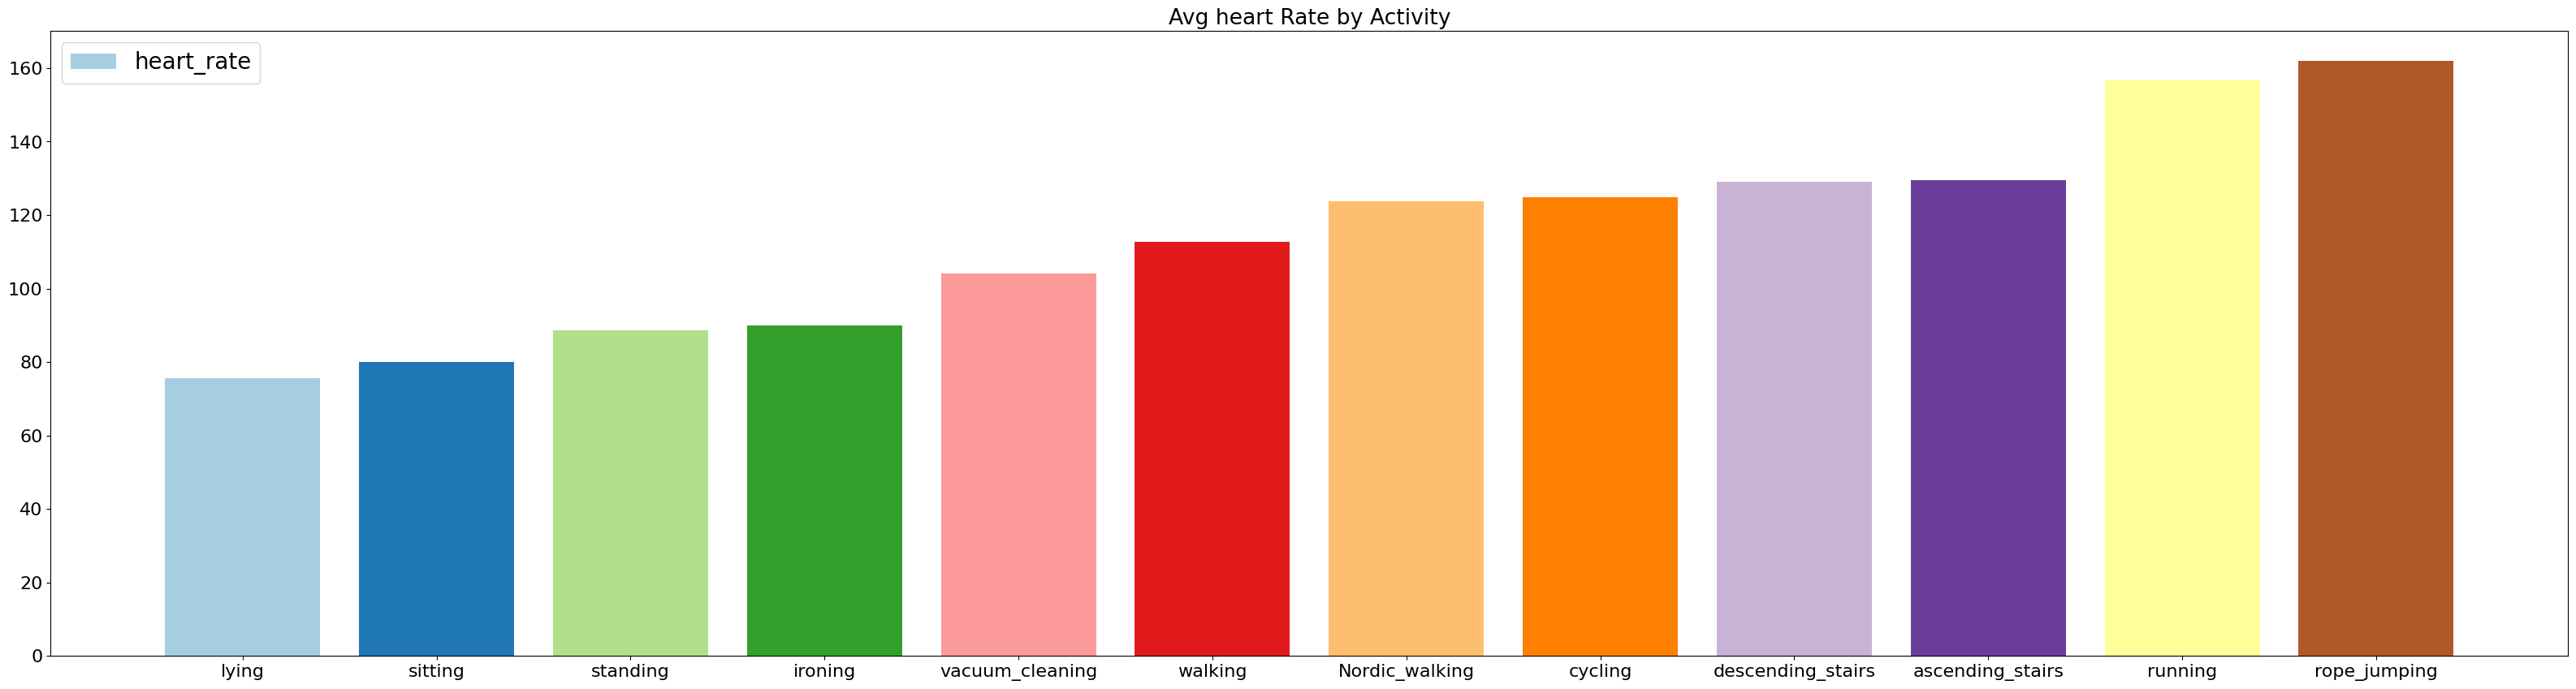

In [13]:
map_ac = load_activity_map()
sampels_heart_rate = pd.DataFrame()
sampels_heart_rate['activity'] = [map_ac[x] for x in result_act['activity_id']]
sampels_heart_rate['heart_rate'] = result_act['heart_rate']
sampels_heart_rate = sampels_heart_rate.sort_values(by=['heart_rate'])
pd_fast_plot(sampels_heart_rate,'heart_rate','activity','Avg heart Rate by Activity',figsize=(40,10))

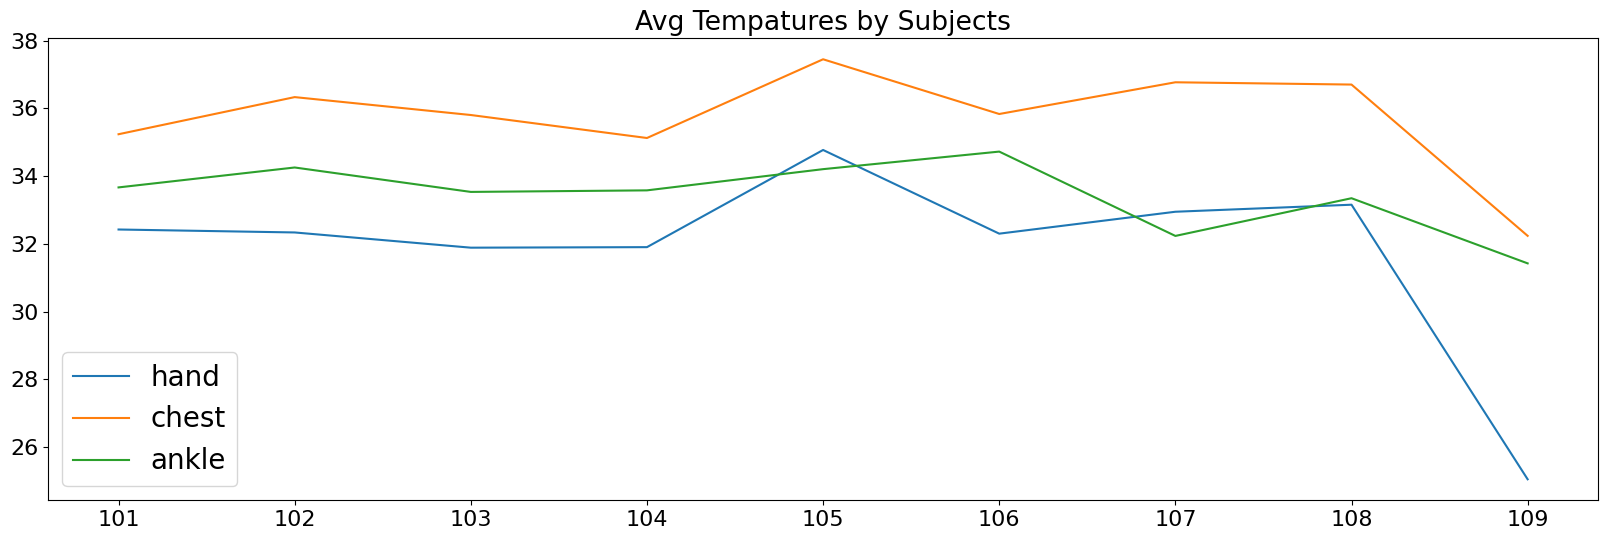

In [14]:
samepls_tempreture = pd.DataFrame()
samepls_tempreture['hand'] = result_id['hand_temperature']
samepls_tempreture['chest'] = result_id['chest_temperature']
samepls_tempreture['ankle'] = result_id['ankle_temperature']

ax = samepls_tempreture.plot(kind='line', figsize=(20,6), title='Avg Tempatures by Subjects')
c = ax.set_xticks(np.arange(len(samepls_tempreture)))
a = ax.set_xticklabels(result_id['id'])
b = ax.legend(fontsize = 20)

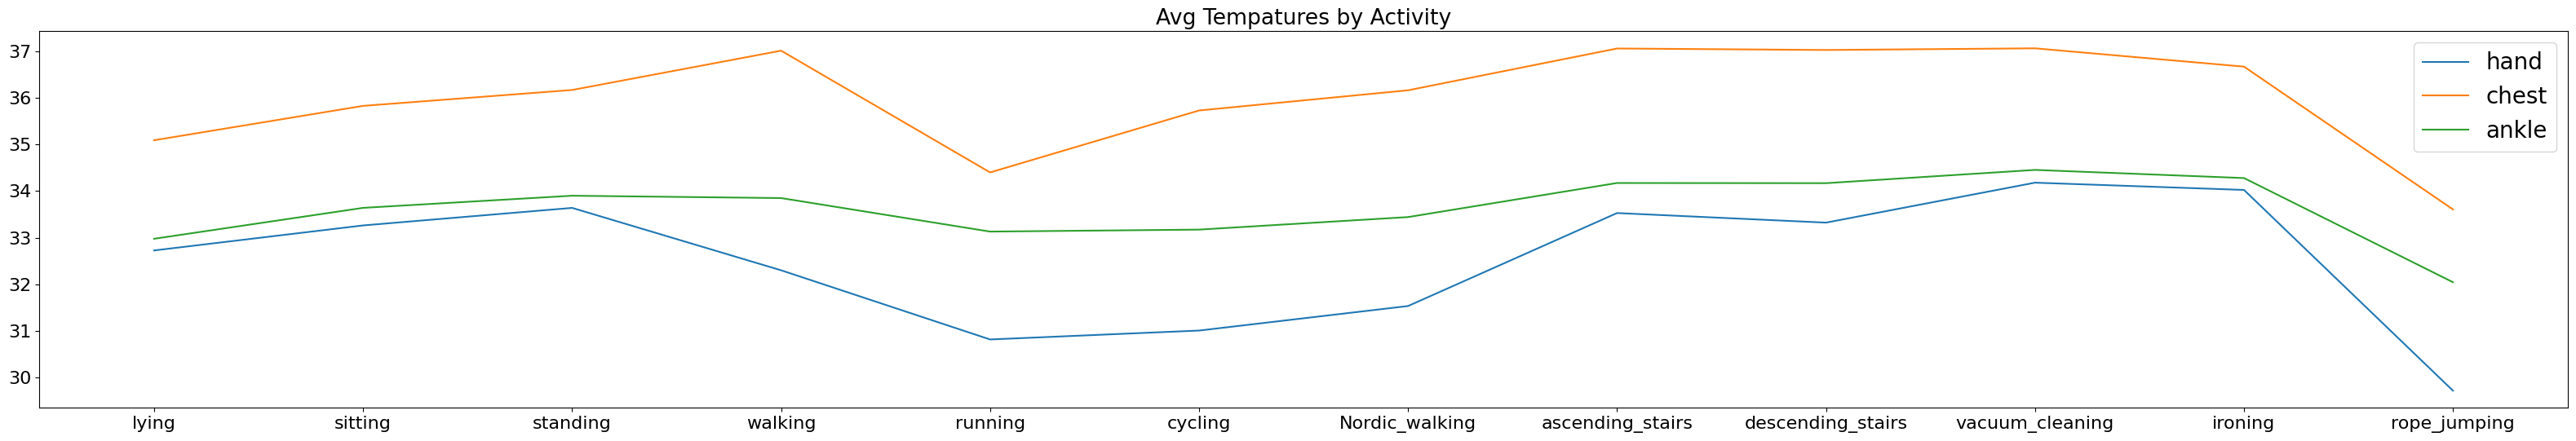

In [15]:
map_ac = load_activity_map()
samepls_tempreture = pd.DataFrame()
samepls_tempreture['activity'] = [map_ac[x] for x in result_act['activity_id']]
samepls_tempreture['hand'] = result_act['hand_temperature']
samepls_tempreture['chest'] = result_act['chest_temperature']
samepls_tempreture['ankle'] = result_act['ankle_temperature']

ax = samepls_tempreture.plot(kind='line', figsize=(40,6), title='Avg Tempatures by Activity')
c = ax.set_xticks(np.arange(len(samepls_tempreture)))
a = ax.set_xticklabels(samepls_tempreture['activity'])
b = ax.legend(fontsize = 20)

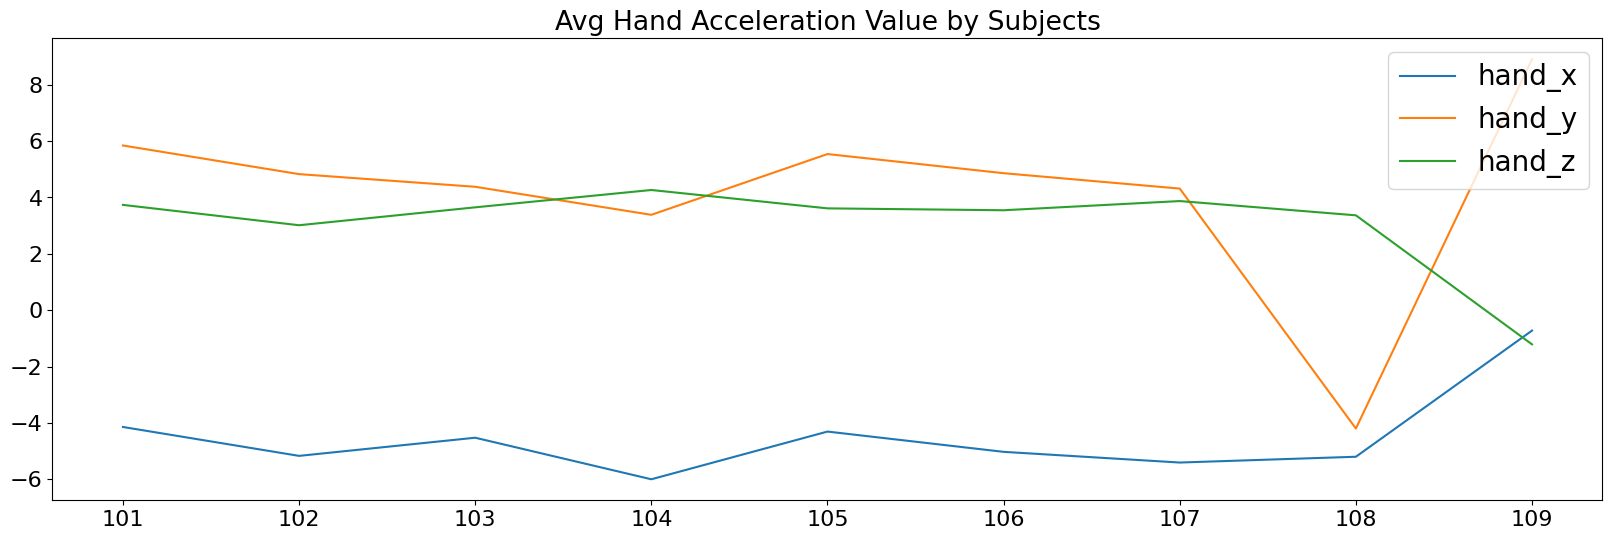

In [16]:
samepls = pd.DataFrame()
samepls['hand_x'] = result_id['hand_3D_acceleration_16_x']
samepls['hand_y'] = result_id['hand_3D_acceleration_16_y']
samepls['hand_z'] = result_id['hand_3D_acceleration_16_z']
ax = samepls.plot(kind='line', figsize=(20,6), title='Avg Hand Acceleration Value by Subjects')
c = ax.set_xticks(np.arange(len(samepls)))
a = ax.set_xticklabels(result_id['id'])
b = ax.legend(fontsize = 20)